### Область работы 1 (библиотеки)

In [513]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import GridSearchCV,train_test_split

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,r2_score,make_scorer


### Область работы 2 (поиск  модели .... )

In [176]:
path_train = 'train.csv'
data = pd.read_csv(path_train)
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.55,Ideal,I,SI1,61.7,55.0,1134,5.29,5.31,3.27
1,0.94,Premium,E,SI1,62.4,56.0,4580,6.27,6.24,3.90
2,0.33,Premium,E,SI2,60.0,59.0,594,4.49,4.47,2.69
3,0.31,Ideal,D,VS2,59.4,56.0,879,4.45,4.40,2.63
4,2.01,Very Good,H,SI1,62.8,59.0,17759,7.99,8.04,5.03


##### Прописываем метрику,объясняющую,насколько хорошо мы предсказываем сильно высокие,либо же сильно низкие значения цены

In [3]:
def irq_mse(y_true, y_predict):
    delta = y_predict-y_true
    Q25 = np.quantile(delta, 0.25)
    Q75 = np.quantile(delta, 0.75)
    irq = Q75-Q25
    mask = (delta<(Q25-1.5*irq)) | (delta> (Q75+1.5*irq))
    if (mask.sum()==0):
        rez=0
    else: rez = -sum((delta[mask])**2) / mask.sum()
    return rez

In [4]:
irq_mse_score=make_scorer(irq_mse)

In [384]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40377 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40377 non-null  float64
 1   cut      40377 non-null  object 
 2   color    40377 non-null  object 
 3   clarity  40377 non-null  object 
 4   depth    40377 non-null  float64
 5   table    40377 non-null  float64
 6   price    40377 non-null  int64  
 7   x        40377 non-null  float64
 8   y        40377 non-null  float64
 9   z        40377 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


In [383]:
data.describe()

,carat,depth,table,price,x,y,z
count,40377.00000,40377.000000,40377.000000,40377.000000,40377.000000,40377.000000,40377.000000
mean,0.79713,61.745600,57.452126,3938.759690,5.728777,5.732886,3.537583
std,0.47404,1.420043,2.231121,3998.041468,1.122689,1.152500,0.709028
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,946.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.000000,6.540000,6.530000,4.030000
max,5.01000,78.200000,95.000000,18818.000000,10.740000,58.900000,31.800000


##### максимальная ширина (y) 58 мм, максимальная глубина(z) 31 мм?

In [386]:
data['y']=np.where(data['y']>=15, data['y']/10,data['y'])
data['z']=np.where(data['z']>=15, data['z']/10,data['z'])

In [385]:
data.drop_duplicates(inplace=True)

In [387]:
data.describe()

,carat,depth,table,price,x,y,z
count,40377.00000,40377.000000,40377.000000,40377.000000,40377.000000,40377.000000,40377.000000
mean,0.79713,61.745600,57.452126,3938.759690,5.728777,5.730864,3.536874
std,0.47404,1.420043,2.231121,3998.041468,1.122689,1.114259,0.694939
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,946.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.000000,6.540000,6.530000,4.030000
max,5.01000,78.200000,95.000000,18818.000000,10.740000,10.540000,8.060000


##### Посмотрим на графиках ,как ведут себя переменные 

<Axes: xlabel='clarity', ylabel='price'>

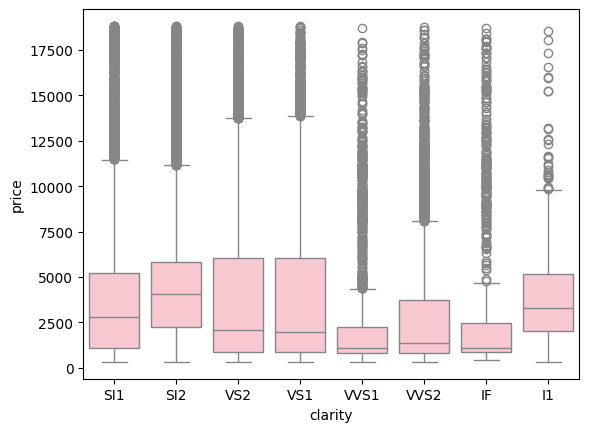

In [533]:
sns.boxplot(data=data,x=data.clarity,y=data.price,color='pink')

<Axes: xlabel='color', ylabel='price'>

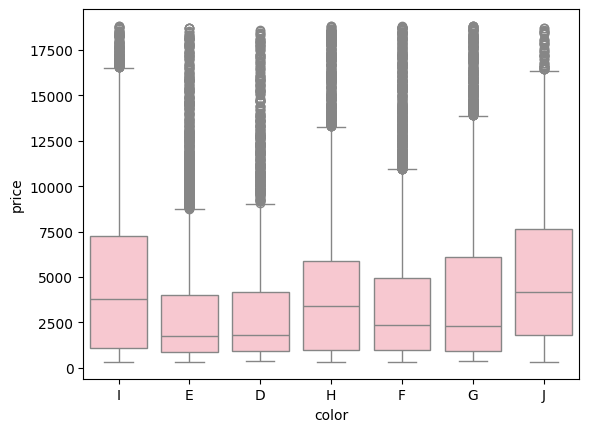

In [531]:
sns.boxplot(data=data,x=data.color,y=data.price,color='pink')

<Axes: xlabel='cut', ylabel='price'>

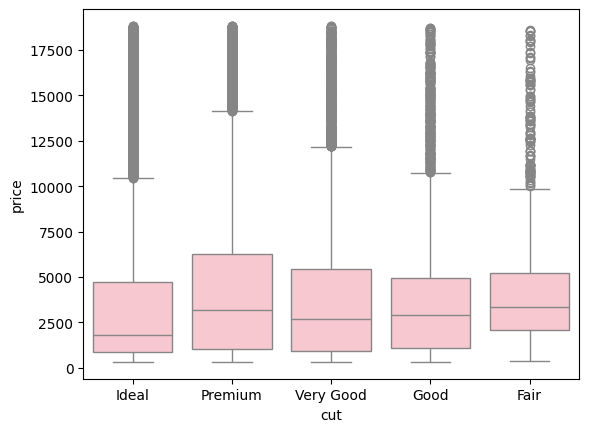

In [530]:
sns.boxplot(data=data,x=data.cut,y=data.price,color='pink')

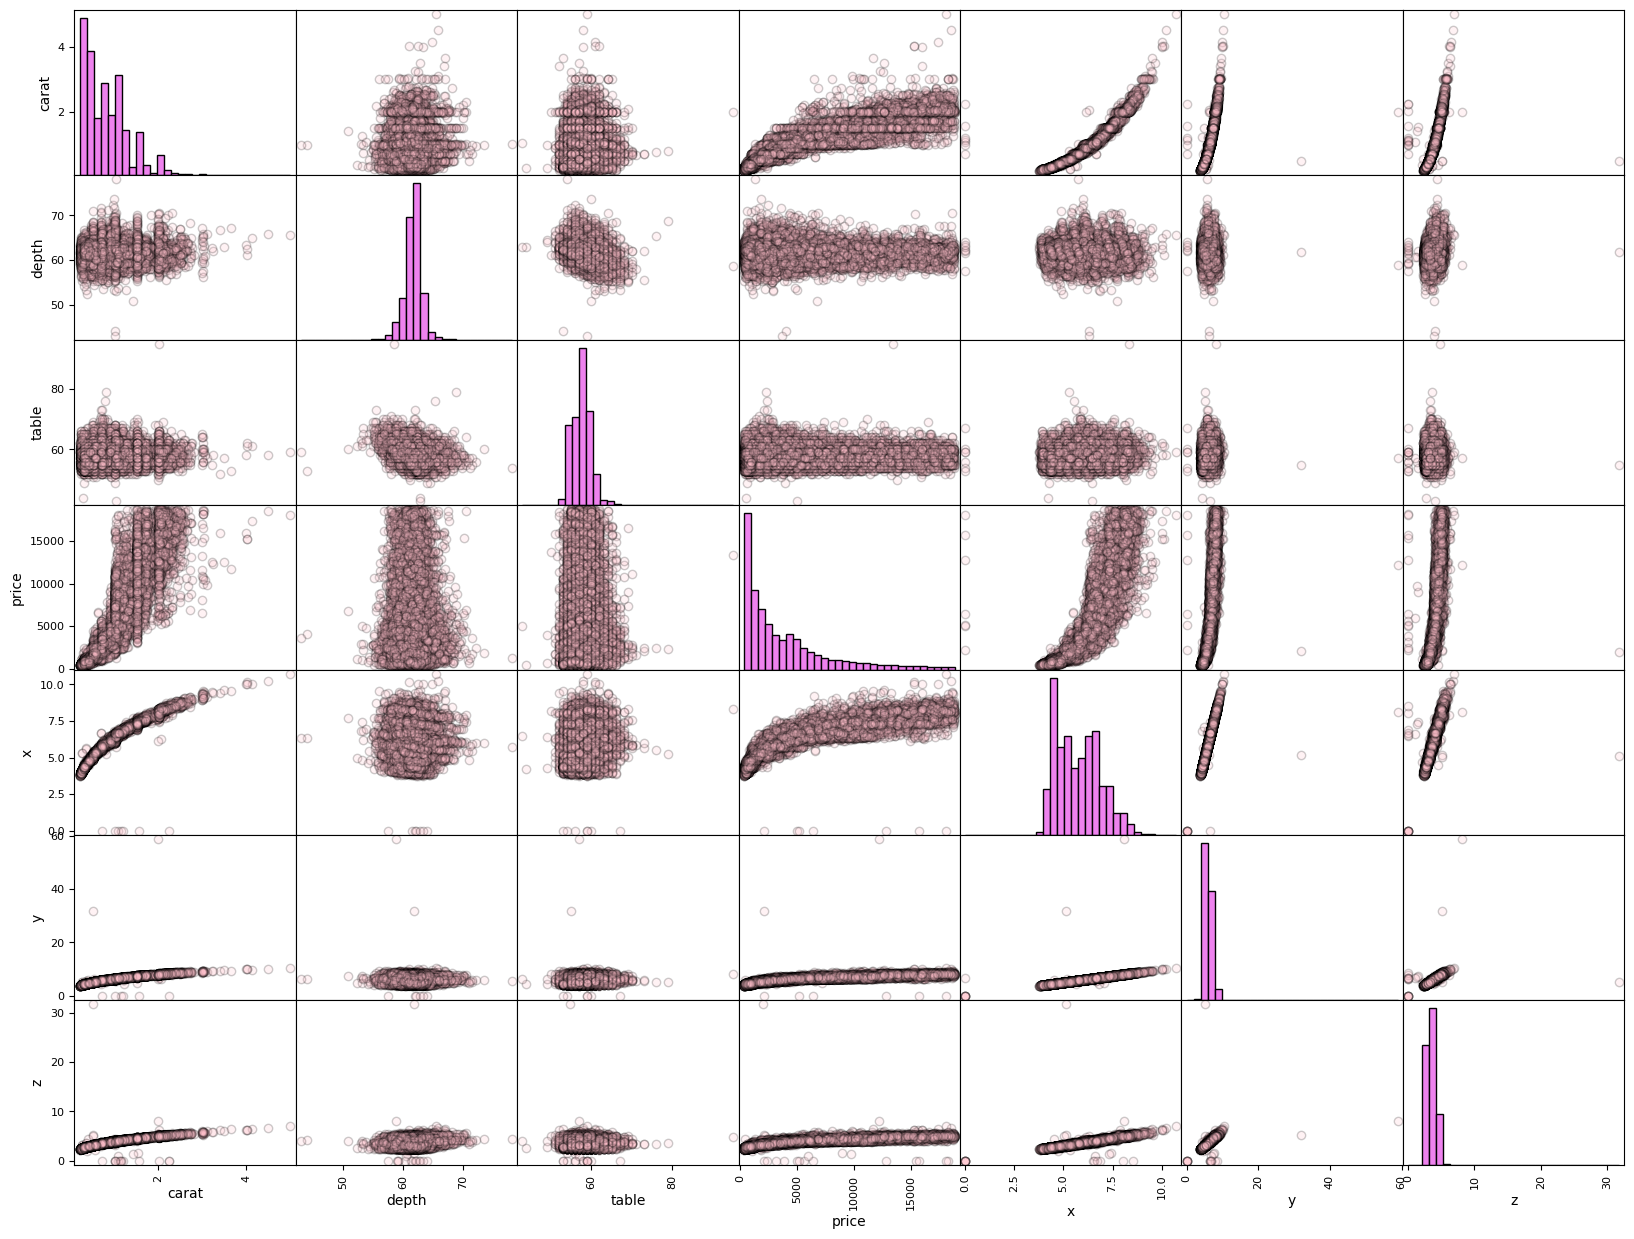

In [180]:
pd.plotting.scatter_matrix(data,
                           alpha = 0.2, figsize = (20, 15), marker = "o",color='pink',
                           hist_kwds = dict(edgecolor = "black", color='violet',linewidth = 1, bins = 30),
                           edgecolors = "black")
plt.show()

###### Между переменными x,y,z видна сильная линейная взаимосвязь,цена распределена ненормально, и впринципе регрессоры нелинейны по цене

<Axes: >

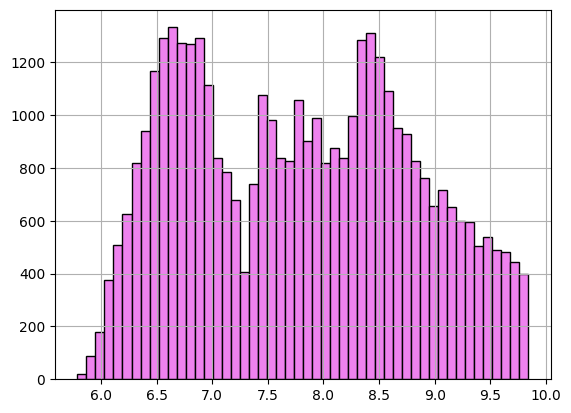

In [183]:
(pd.Series(np.log(data['price'])).hist(bins=50,color='violet',edgecolor='k')) #прологарифмировав цену получим что-то близкое к нормальному

In [388]:
X=data.drop('price',axis=1)
y=np.log(data['price'])


In [389]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [390]:
cat_features=['cut','color']
axis_features = ['x','y','z']
num_features = ['carat','depth','table']


In [391]:
clarity_map = [{
    'col':'clarity',
    'mapping':{'FL':10, 'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 
               'SI1':4, 'SI2':3, 'I1':2, 'I2':1, 'I3':0}
    }]

In [408]:
clarity_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ])    

In [393]:
### пишем трансформер
axis_transformer = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=0,max_iter=20)),
    ('polynom', PolynomialFeatures(3,include_bias=False)),
    ('scaler', RobustScaler()),
])

num = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=0,max_iter=20))
     ,
    ('scaler', RobustScaler())])
CT = ColumnTransformer([
        ("axis_transformer", axis_transformer, axis_features),
        ("num", num, num_features),
        ("ordinal_map", clarity_transformer, ['clarity']),
  ("ohe",OneHotEncoder(sparse_output=False), cat_features)
        ]).set_output(transform='pandas')
display(CT)

ColumnTransformer(transformers=[('axis_transformer',
                                 Pipeline(steps=[('missing_num',
                                                  IterativeImputer(max_iter=20,
                                                                   missing_values=0)),
                                                 ('polynom',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['x', 'y', 'z']),
                                ('num',
                                 Pipeline(steps=[('missing_num',
                                                  IterativeImputer(max_iter=20,
                                                                   missing_values=0)),
                                                 ('scaler', RobustScaler())]),
                                 ['carat', 'depth', 'table']),
                                ('ordinal_map',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64}]))]),
                                 ['clarity']),
                                ('ohe', OneHotEncoder(sparse_output=False),
                                 ['cut', 'color'])])

In [394]:
ct = CT.fit_transform(X_train)
pd.DataFrame(ct).head().T

,24432,6505,33056,30752,3919
axis_transformer__x,1.401099,0.961538,0.961538,0.456044,0.005495
axis_transformer__y,1.436464,0.977901,0.928177,0.370166,0.022099
axis_transformer__z,1.401786,0.946429,0.946429,0.455357,-0.017857
axis_transformer__x^2,1.736415,1.123221,1.123221,0.495400,0.005568
axis_transformer__x y,1.760386,1.132090,1.099282,0.443509,0.011230
axis_transformer__x z,1.764854,1.129114,1.129114,0.498772,-0.012446
axis_transformer__y^2,1.790153,1.146534,1.080810,0.397805,0.022512
axis_transformer__y z,1.794964,1.143866,1.110483,0.451667,-0.000761
axis_transformer__z^2,1.739103,1.104621,1.104621,0.495381,-0.018063
axis_transformer__x^3,2.157166,1.308424,1.308424,0.534312,0.005593


### Рассмотрим Модели Ridge,KNNRegressor,SVR

#### Ridge

In [403]:
model_ridge = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', Ridge(alpha=10)),
                            ])
model_ridge.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('axis_transformer',
                                                  Pipeline(steps=[('missing_num',
                                                                   IterativeImputer(max_iter=20,
                                                                                    missing_values=0)),
                                                                  ('polynom',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['x', 'y', 'z']),
                                                 ('num',
                                                  Pipeline(steps=[('missing_num',
                                                                   IterativeImputer(max_iter=20,
                                                                                    missing_values=0)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['carat', 'depth', 'table']),
                                                 ('ordinal_map',
                                                  Pipeline(steps=[('ce',
                                                                   OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                            'data_type': dtype('O'),
                                                                                            'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64}]))]),
                                                  ['clarity']),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['cut', 'color'])])),
                ('estimator', Ridge(alpha=10))])

In [404]:
y_ridge = model_ridge.predict(X_test)

In [405]:
mean_squared_error(np.exp(y_test),np.exp(y_ridge))#не забываем привести цену к изначальному виду

640310.2238567759

In [406]:
r2_score(y_test,y_ridge)

0.9815043817168833

In [407]:
irq_mse(np.exp(y_test),np.exp(y_ridge)) 

-3442980.3572665

##### KNR

In [431]:
model_knn = Pipeline(steps=[
    ('preproc', CT),
    ('estimator',  KNeighborsRegressor(n_neighbors=5,weights='distance',algorithm='ball_tree',p=1))
    ])

model_knn.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('axis_transformer',
                                                  Pipeline(steps=[('missing_num',
                                                                   IterativeImputer(max_iter=20,
                                                                                    missing_values=0)),
                                                                  ('polynom',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['x', 'y', 'z']),
                                                 ('num',
                                                  Pipeline(steps=[('missing_num',
                                                                   IterativeImputer(max_iter=20,
                                                                                    missing_values=0)),
                                                                  ('s...
                                                  ['carat', 'depth', 'table']),
                                                 ('ordinal_map',
                                                  Pipeline(steps=[('ce',
                                                                   OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                            'data_type': dtype('O'),
                                                                                            'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64}]))]),
                                                  ['clarity']),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['cut', 'color'])])),
                ('estimator',
                 KNeighborsRegressor(algorithm='ball_tree', p=1,
                                     weights='distance'))])

In [432]:
knn= model_knn.predict(X_test)

In [433]:
mean_squared_error(np.exp(y_test),np.exp(knn))

520803.85501116014

In [434]:
irq_mse(np.exp(y_test),np.exp(knn))

-2889694.852231079

#### SVR

In [438]:
model_svr = Pipeline(steps=[
    ('preproc', CT),
    ('estimator', SVR(C=10,kernel='rbf'))
    ])
model_svr.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('axis_transformer',
                                                  Pipeline(steps=[('missing_num',
                                                                   IterativeImputer(max_iter=20,
                                                                                    missing_values=0)),
                                                                  ('polynom',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['x', 'y', 'z']),
                                                 ('num',
                                                  Pipeline(steps=[('missing_num',
                                                                   IterativeImputer(max_iter=20,
                                                                                    missing_values=0)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['carat', 'depth', 'table']),
                                                 ('ordinal_map',
                                                  Pipeline(steps=[('ce',
                                                                   OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                            'data_type': dtype('O'),
                                                                                            'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64}]))]),
                                                  ['clarity']),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['cut', 'color'])])),
                ('estimator', SVR(C=10))])

In [439]:
y_svr=model_svr.predict(X_test)

In [440]:
irq_mse(np.exp(y_test),np.exp(y_svr))

-1939913.9978898347

In [441]:
mean_squared_error(np.exp(y_test),np.exp(y_svr))

358208.29533930635

In [499]:
r2_score(np.exp(y_test),np.exp(y_svr))

0.977945028536328

##### Сравним модели на скаттер плотах

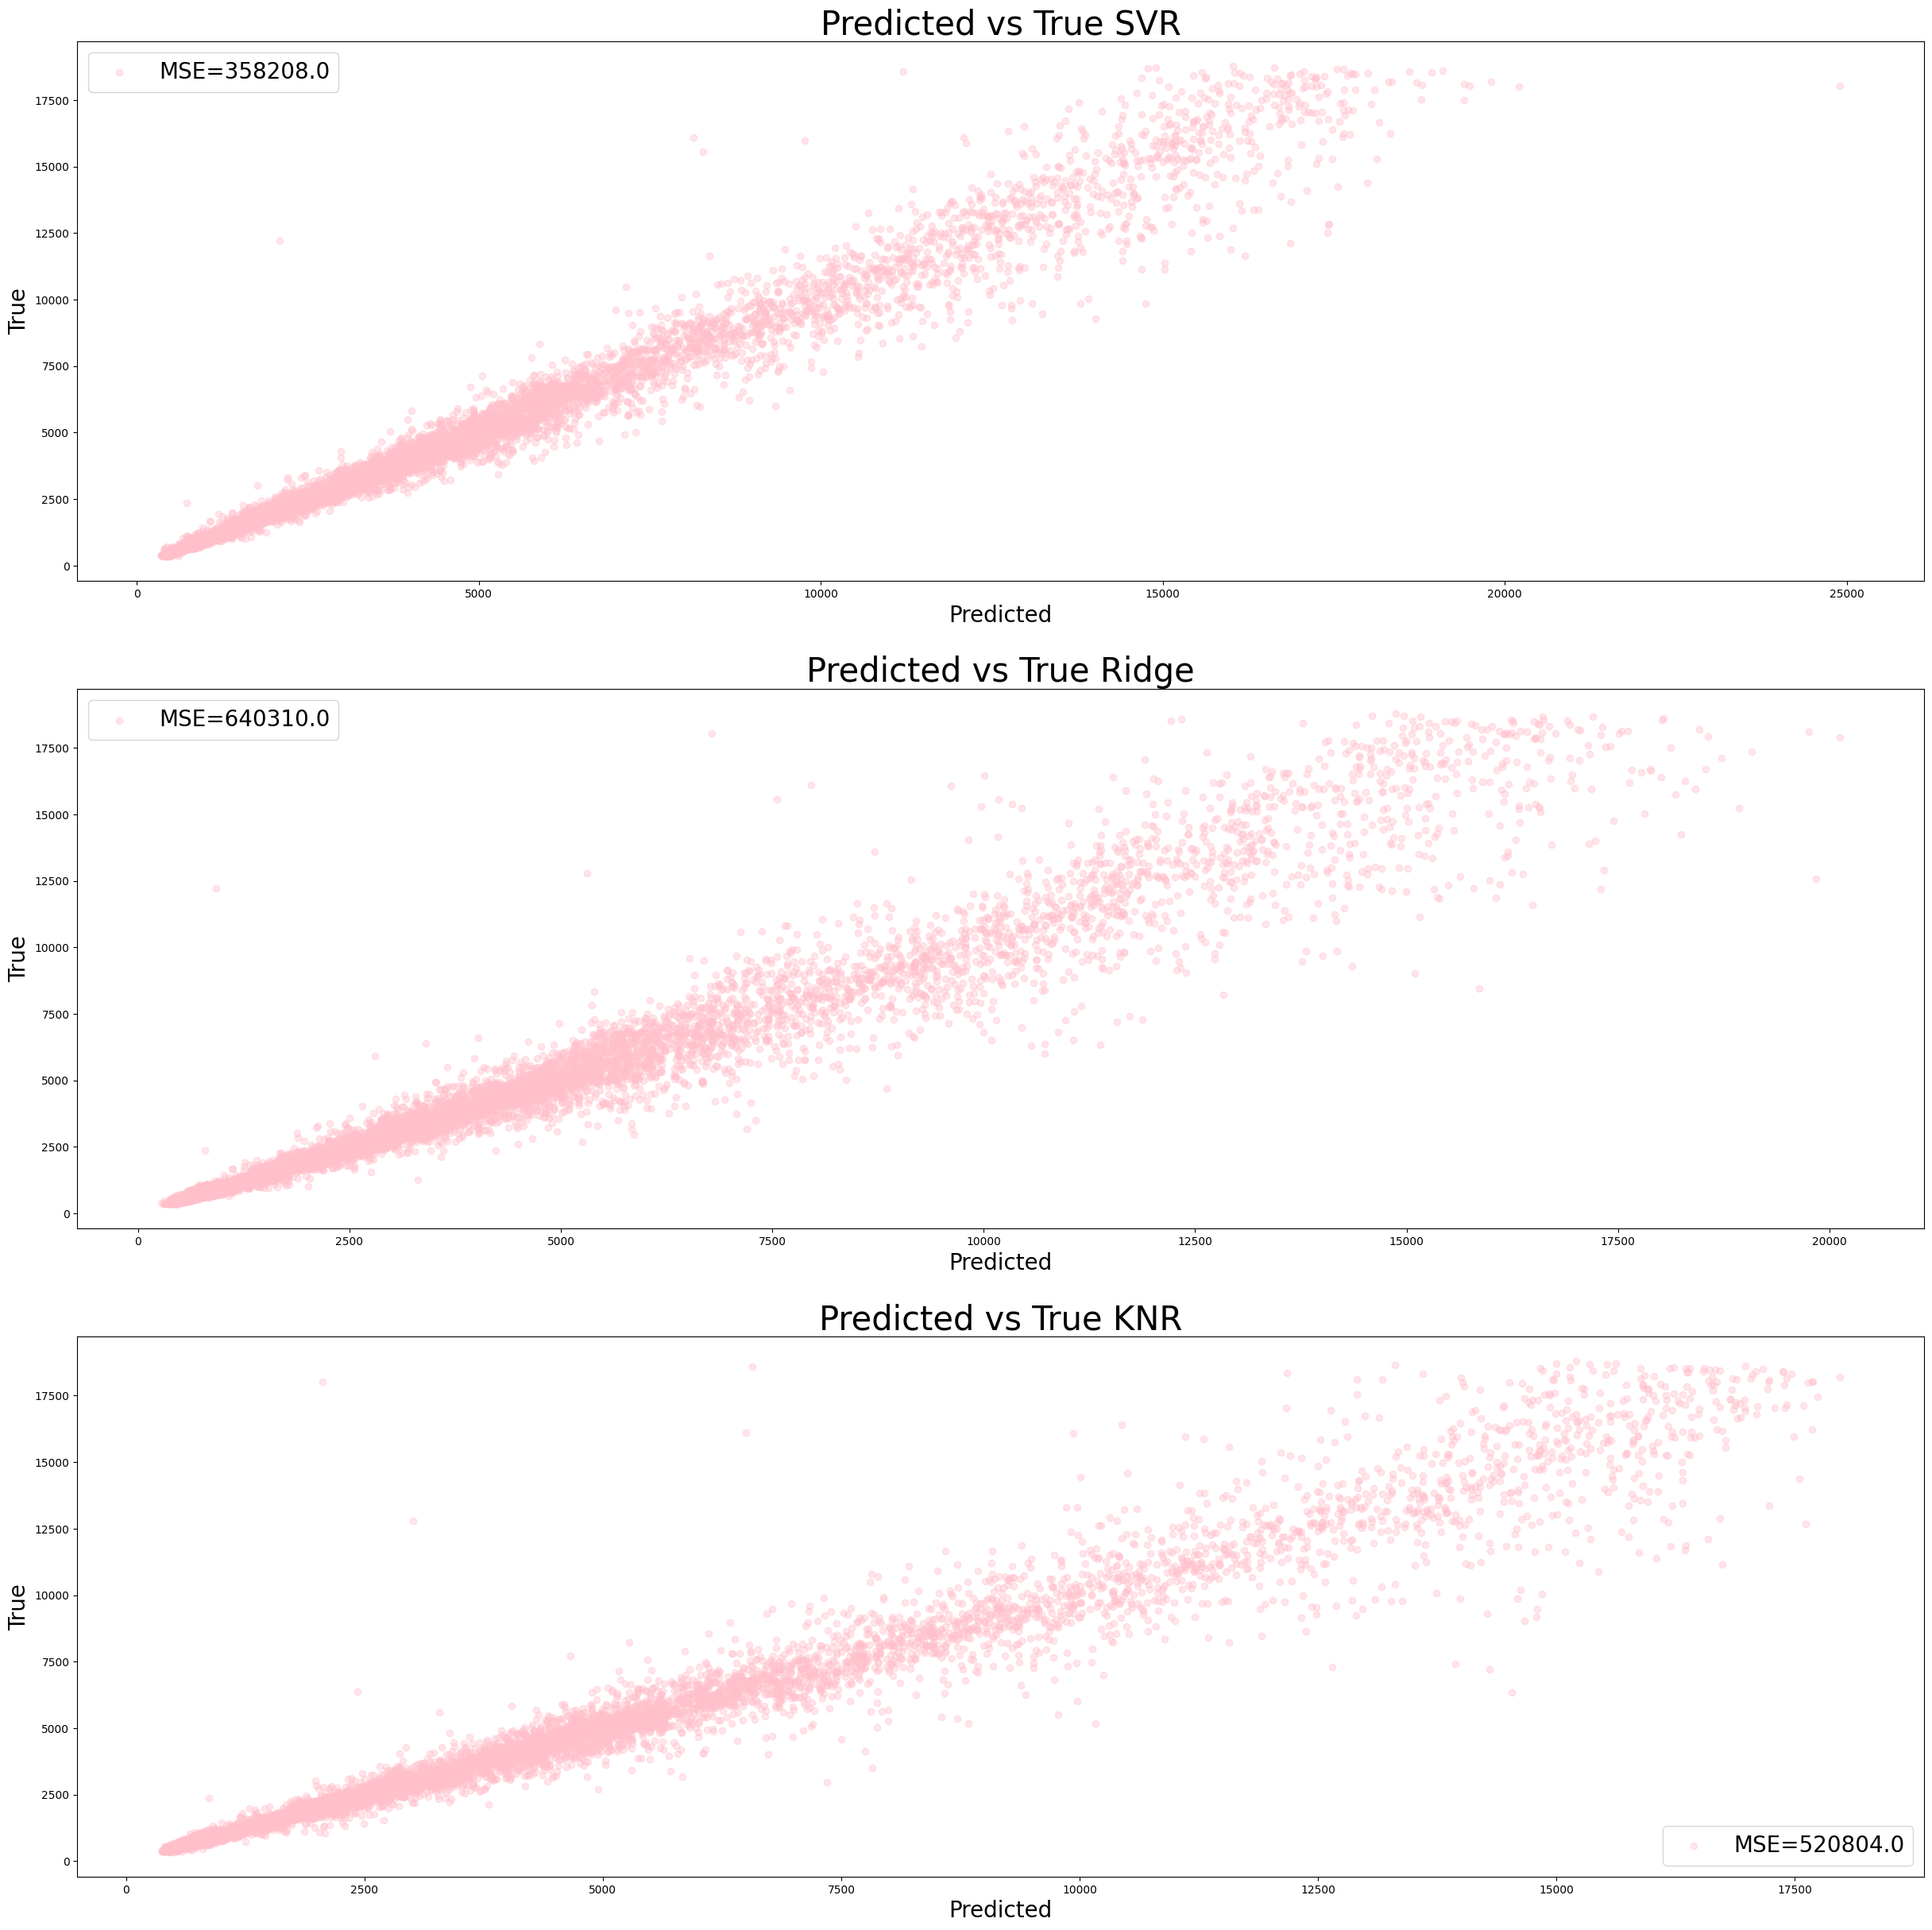

In [512]:

fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(30,30))

ax[0].scatter(np.exp(y_svr),np.exp(y_test),color='pink',alpha=0.4,label=f'MSE={np.round(mean_squared_error(np.exp(y_test),np.exp(y_svr)))}')
ax[0].legend(fontsize=20)
ax[0].set_title("Predicted vs True SVR",fontsize=30)
ax[1].scatter(np.exp(y_ridge),np.exp(y_test),color='pink',alpha=0.4,label=f'MSE={np.round(mean_squared_error(np.exp(y_test),np.exp(y_ridge)))}')
ax[1].set_title("Predicted vs True Ridge",fontsize=30)
ax[1].legend(fontsize=20)
plt.scatter(np.exp(knn),np.exp(y_test),color='pink',alpha=0.4,label=f'MSE={np.round(mean_squared_error(np.exp(y_test),np.exp(knn)))}')
ax[2].set_title("Predicted vs True KNR",fontsize=30)
ax[2].legend(fontsize=20)
for i in range(3):
    ax[i].set_xlabel("Predicted",fontsize=20)
    ax[i].set_ylabel("True",fontsize=20)

#### Наилучшей моделью оказалась SVR 